In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import pandas as pd 
import random
import plotnine
from plotnine import * 
np.random.seed(1234)
random.seed(1234)


In [2]:
import tensorflow
tensorflow.compat.v1.enable_eager_execution()
from tensorflow.compat.v1.keras.backend import get_session
#tensorflow.compat.v1.disable_v2_behavior()


In [3]:
#load the data 
entries=pickle.load(open('../cnn_inputs.p','rb'))
X=entries['X']
y=entries['y']

In [4]:
#create train,test,validate splits 
indices=list(X.keys())
substrate="AJUBA"
indices_to_use=[i for i in indices if i.startswith(substrate)]
random.shuffle(indices_to_use)
num_items=len(indices_to_use)
#split 70% train, 15% validate, 15% test 
num_train=int(round(0.7*num_items))
num_validate=int(round(0.15*num_items))
num_test=num_items-num_train-num_validate 

In [5]:
print(num_train)
print(num_validate)
print(num_test)

190
41
40


In [6]:
train_indices=indices_to_use[0:num_train]
validate_indices=indices_to_use[num_train:num_train+num_validate]
test_indices=indices_to_use[num_train+num_validate::]


In [7]:
train_X_seq=np.array([X[i][0] for i in train_indices])
train_X_struct=np.array([X[i][1] for i in train_indices])
train_X=[train_X_seq,train_X_struct]

validate_X_seq=np.array([X[i][0] for i in validate_indices])
validate_X_struct=np.array([X[i][1] for i in validate_indices])
validate_X=[validate_X_seq,validate_X_struct]

test_X_seq=np.array([X[i][0] for i in test_indices])
test_X_struct=np.array([X[i][1] for i in test_indices])
test_X=[test_X_seq,test_X_struct]

In [8]:
train_indices

['AJUBA_BC_086',
 'AJUBA_BC_052',
 'AJUBA_BC_002',
 'AJUBA_BC_034',
 'AJUBA_BC_212',
 'AJUBA_BC_158',
 'AJUBA_BC_083',
 'AJUBA_BC_103',
 'AJUBA_BC_254',
 'AJUBA_BC_213',
 'AJUBA_BC_093',
 'AJUBA_BC_134',
 'AJUBA_BC_173',
 'AJUBA_BC_105',
 'AJUBA_BC_221',
 'AJUBA_BC_176',
 'AJUBA_BC_251',
 'AJUBA_BC_180',
 'AJUBA_BC_062',
 'AJUBA_BC_091',
 'AJUBA_BC_161',
 'AJUBA_BC_133',
 'AJUBA_BC_228',
 'AJUBA_BC_151',
 'AJUBA_BC_057',
 'AJUBA_BC_032',
 'AJUBA_BC_157',
 'AJUBA_BC_125',
 'AJUBA_BC_227',
 'AJUBA_BC_260',
 'AJUBA_BC_140',
 'AJUBA_BC_269',
 'AJUBA_BC_107',
 'AJUBA_BC_191',
 'AJUBA_BC_215',
 'AJUBA_BC_067',
 'AJUBA_BC_072',
 'AJUBA_BC_162',
 'AJUBA_BC_250',
 'AJUBA_BC_143',
 'AJUBA_BC_220',
 'AJUBA_BC_094',
 'AJUBA_BC_258',
 'AJUBA_BC_159',
 'AJUBA_BC_014',
 'AJUBA_BC_194',
 'AJUBA_BC_156',
 'AJUBA_BC_249',
 'AJUBA_BC_061',
 'AJUBA_BC_037',
 'AJUBA_BC_099',
 'AJUBA_BC_066',
 'AJUBA_BC_205',
 'AJUBA_BC_199',
 'AJUBA_BC_178',
 'AJUBA_BC_044',
 'AJUBA_BC_235',
 'AJUBA_BC_115',
 'AJUBA_BC_092

In [9]:
train_y=np.asarray([y[i] for i in train_indices])
validate_y=np.asarray([y[i] for i in validate_indices])
test_y=np.asarray([y[i] for i in test_indices])

In [10]:
train_X_seq.shape

(190, 166, 4)

In [11]:
train_X_struct.shape

(190, 166, 6)

In [12]:
train_y.shape

(190,)

## Create keras model 

In [13]:
#import keras dependencies 
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Concatenate
from keras.layers.core import  Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras import backend as K
from kerasAC.custom_losses import * 

Using TensorFlow backend.


In [14]:
#define a keras model 
K.set_image_data_format('channels_last')
padding='same'
seq_input=Input(shape=(166,4),name='seq_input')
struct_input=Input(shape=(166,6),name='struct_input')
x_seq=Conv1D(filters=10,kernel_size=6,input_shape=(166,4),padding=padding,name='conv_seq')(seq_input)
x_struct=Conv1D(filters=10,kernel_size=6,input_shape=(166,6),padding=padding,name='conv_struct')(struct_input)
x_seq=BatchNormalization(name='batch_normalization_1')(x_seq)
x_struct=BatchNormalization(name='batch_normalization_2')(x_struct)
x_seq=Activation('relu',name='activation_1')(x_seq)
x_struct=Activation('relu',name='activation_2')(x_struct)
aggregated=Concatenate(axis=-1)([x_struct,x_seq])
x=Flatten(name='flatten1')(aggregated)
x=Dense(8,name='dense1')(x)
x=Activation('relu',name='activation_3')(x)
outputs=Dense(1,name='final')(x)
model=Model(inputs=[seq_input,struct_input],outputs=outputs)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam,loss=ambig_mean_squared_error)


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
struct_input (InputLayer)       (None, 166, 6)       0                                            
__________________________________________________________________________________________________
seq_input (InputLayer)          (None, 166, 4)       0                                            
__________________________________________________________________________________________________
conv_struct (Conv1D)            (None, 166, 10)      370         struct_input[0][0]               
__________________________________________________________________________________________________
conv_seq (Conv1D)               (None, 166, 10)      250         seq_input[0][0]                  
____________________________________________________________________________________________

## Train the model 

In [16]:
from keras.callbacks import * 
from kerasAC.custom_callbacks import * 


In [17]:
#define callbacks 
checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)
history=LossHistory("logs.batch",['loss','val_loss'])
csvlogger = CSVLogger("logs.epoch.csv", append = False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00000001)
cur_callbacks=[checkpointer,earlystopper,csvlogger,reduce_lr,history]


In [18]:
#fit the model 
model.fit(x=train_X,
          y=train_y,
          batch_size=32,
          epochs=40,
          verbose=1,
          callbacks=cur_callbacks,
          validation_data=(validate_X,validate_y),
          shuffle=True,
          max_queue_size=100,
          use_multiprocessing=True,
          workers=12)


Train on 190 samples, validate on 41 samples
Epoch 1/40
190/190 [==============================] - 4s 20ms/step - loss: 0.1586 - val_loss: 0.0105

Epoch 00001: val_loss improved from inf to 0.01054, saving model to model.hdf5
Epoch 2/40
190/190 [==============================] - 0s 318us/step - loss: 0.0121 - val_loss: 0.0097

Epoch 00002: val_loss improved from 0.01054 to 0.00973, saving model to model.hdf5
Epoch 3/40
190/190 [==============================] - 0s 343us/step - loss: 0.0064 - val_loss: 0.0096

Epoch 00003: val_loss improved from 0.00973 to 0.00962, saving model to model.hdf5
Epoch 4/40
190/190 [==============================] - 0s 367us/step - loss: 0.0063 - val_loss: 0.0095

Epoch 00004: val_loss improved from 0.00962 to 0.00948, saving model to model.hdf5
Epoch 5/40
190/190 [==============================] - 0s 338us/step - loss: 0.0062 - val_loss: 0.0093

Epoch 00005: val_loss improved from 0.00948 to 0.00933, saving model to model.hdf5
Epoch 6/40
190/190 [==========

## plot the loss curves 

In [19]:
## plot the losses
losses=pd.read_csv("logs.epoch.csv",header=0,sep=',')
losses.shape
batch_losses=pd.read_csv("logs.batch",header=0,sep='\t')
losses=pd.melt(losses,id_vars='epoch')
losses['variable'][losses['variable']=='loss']='TrainingLoss'
losses['variable'][losses['variable']=='val_loss']='ValidationLoss'
plotnine.options.figure_size = (6, 6)
(ggplot(losses,aes(x='epoch',
                   y='value',
                   group='variable',
                   color='variable'))+geom_line(size=2)+theme_bw(20)).save("Loss.svg",format='svg')


/users/annashch/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/annashch/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/users/annashch/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/users/annashch/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Loss.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)


## get predictions

In [20]:
predictions_test=model.predict(test_X,batch_size=128,max_queue_size=100,use_multiprocessing=True,workers=4)

In [21]:
predictions_train=model.predict(train_X,batch_size=128,max_queue_size=100,use_multiprocessing=True,workers=4)

In [22]:
predictions_validate=model.predict(validate_X,batch_size=128,max_queue_size=100,use_multiprocessing=True,workers=4)

In [23]:
#get performance metrics 
from kerasAC.performance_metrics.regression_performance_metrics import *
test_perf=get_performance_metrics_regression(predictions_test,np.expand_dims(test_y,axis=1))
test_perf

predictions shape:(40, 1)
true labels shape:(40, 1)


/users/annashch/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/users/annashch/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/users/annashch/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/users/annashch/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/users/annashch/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/users/annashch/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is c

{'spearmanr': [SpearmanrResult(correlation=nan, pvalue=nan)],
 'pearsonr': [(nan, nan)],
 'spearmanr_nonzerobins': [SpearmanrResult(correlation=nan, pvalue=nan)],
 'pearsonr_nonzerobins': [(nan, nan)]}

In [30]:
predictions_test

array([[0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276],
       [0.03662276]], dtype=float32)

In [24]:
train_perf=get_performance_metrics_regression(predictions_train,np.expand_dims(train_y,axis=1))
train_perf

predictions shape:(190, 1)
true labels shape:(190, 1)


{'spearmanr': [SpearmanrResult(correlation=-0.04509753427230914, pvalue=0.5366814839288306)],
 'pearsonr': [(-0.03608856038119826, 0.6210767241409302)],
 'spearmanr_nonzerobins': [SpearmanrResult(correlation=-0.047168243037180355, pvalue=0.5203649584654853)],
 'pearsonr_nonzerobins': [(-0.03675658709946574, 0.6165196432131974)]}

In [25]:
valid_perf=get_performance_metrics_regression(predictions_validate,np.expand_dims(validate_y,axis=1))
valid_perf

predictions shape:(41, 1)
true labels shape:(41, 1)


{'spearmanr': [SpearmanrResult(correlation=0.0668211313876853, pvalue=0.6780711452370154)],
 'pearsonr': [(-0.05195320740769062, 0.7470034312909998)],
 'spearmanr_nonzerobins': [SpearmanrResult(correlation=0.062429139066801365, pvalue=0.7019496663067399)],
 'pearsonr_nonzerobins': [(-0.05515640294065728, 0.7353364290099728)]}

In [26]:
#plot the predictions 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, title, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    nan_indices=[i[0] for i in np.argwhere(np.isnan(x))]
    y= np.delete(y, nan_indices, 0)
    x=np.delete(x,nan_indices,0)

    if ax is None :
        fig , ax = plt.subplots(figsize=(4, 3), dpi= 80, facecolor='w', edgecolor='k')
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs,s=1 )
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    plt.title(title)
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

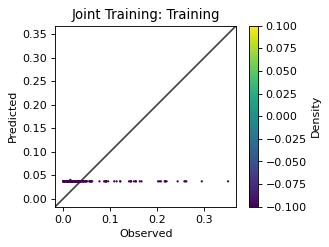

In [27]:
density_scatter(train_y,np.squeeze(predictions_train),'Joint Training: Training',bins=[30,30])


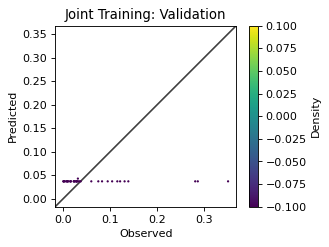

In [28]:
density_scatter(validate_y,np.squeeze(predictions_validate),'Joint Training: Validation',bins=[30,30])

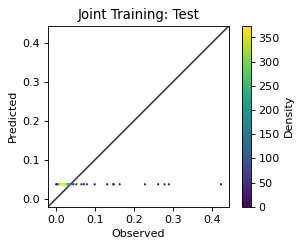

In [29]:
density_scatter(test_y,np.squeeze(predictions_test),'Joint Training: Test',bins=[30,30])
